In [ ]:
# Imports and Setup
import numpy as np
import pandas as pd
from fixed_income_lib.bond_pricing import FixedIncomePrmSingle
from fixed_income_lib.portfolio import FixedIncomePrmPort
from fixed_income_lib.utils.validation import check_yield_curve

import matplotlib.pyplot as plt

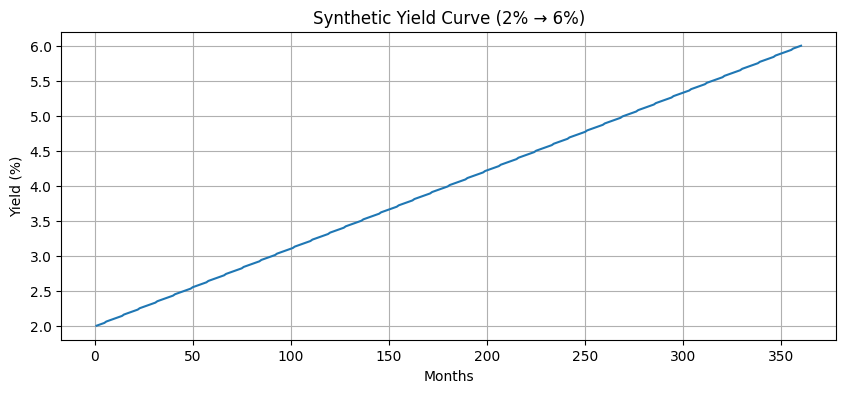

In [ ]:
# Generate a synthetic yield curve
months = np.arange(1, 361)
base_yields = 2 + 4 * (months - 1) / 359
yield_values = np.round(base_yields, 2)
yield_curve_df = pd.DataFrame([yield_values], columns=months)

# Display the yield curve
yield_curve_df.T.plot(legend=False, title="Synthetic Yield Curve (2% → 6%)", figsize=(10, 4))
plt.xlabel("Months")
plt.ylabel("Yield (%)")
plt.grid()
plt.show()

In [ ]:
# Price a single zero-coupon bond
zcb = FixedIncomePrmSingle(
    yield_curve_today=yield_curve_df,
    maturity=5.0,
    is_zcb=True,
    coupon_rate=None,
    semi_annual_payment=False,
    face_value=1000
)
zcb.fit()

print("Zero-Coupon Bond (5Y) Price:", round(zcb.price, 2))
print("Macaulay Duration:", round(zcb.macaulay_duration, 2))
print("Modified Duration:", round(zcb.modified_duration, 2))

Zero-Coupon Bond (5Y) Price: 876.99
Macaulay Duration: 5.0
Modified Duration: 4.87


In [ ]:
# Price a semi-annual coupon bond
bond = FixedIncomePrmSingle(
    yield_curve_today=yield_curve_df,
    maturity=5.0,
    is_zcb=False,
    coupon_rate=0.05,
    semi_annual_payment=True,
    face_value=1000
)
bond.fit()

print("Coupon Bond (5Y, 5% Semi-Annual) Price:", round(bond.price, 2))
print("YTM:", round(bond.ytm, 4))
print("Macaulay Duration:", round(bond.macaulay_duration, 2))
print("Modified Duration:", round(bond.modified_duration, 2))

Coupon Bond (5Y, 5% Semi-Annual) Price: 1111.02
YTM: 0.0262
Macaulay Duration: 4.52
Modified Duration: 4.46


In [ ]:
# Build a small bond portfolio
portfolio = FixedIncomePrmPort(
    yield_curve_today=yield_curve_df,
    maturity_s=[2.0, 5.0, 10.0],
    num_assets_s=[10, -5, 20],
    face_value_s=[1000, 1000, 1000],
    is_zcb_s=[True, False, False],
    coupon_rate_s=[None, 0.04, 0.06],
    semi_annual_payment_s=[False, False, True]
)

summary_df, metrics = portfolio.fit()

print("\nPortfolio Summary:")
display(summary_df)

print("\nPortfolio Metrics:")
print(metrics)


Portfolio Summary:


,maturity,num_assets,face_value,is_zcb,coupon_rate,semi_annual_payment,price,macaulay_duration,modified_duration,position_value,cashflows,cashflow_times,weight
0,2.0,10,1000,True,NaN,False,956.287377,2.000000,1.955799,9562.873772,None,None,0.329347
1,5.0,-5,1000,False,0.04,False,1062.962299,4.642677,4.523293,-5314.811494,"[(1.0, 40.0), (2.0, 40.0), (3.0, 40.0), (4.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0]",-0.183043
2,10.0,20,1000,False,0.06,True,1239.390007,7.935963,7.811536,24787.800141,"[(0.5, 30.0), (1.0, 30.0), (1.5, 30.0), (2.0, ...","[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, ...",0.853696



Portfolio Metrics:
{'portfolio_value': 29035.862419386725, 'portfolio_weighted_modified_duration': 6.484856528813077}


In [ ]:
# Create historical yield curves and compute risk metrics
def generate_historical_yield_curve(base_curve, days=20):
    base = base_curve.values[0]
    data = []
    for _ in range(days):
        noise = np.random.normal(0, 0.1, size=base.shape)
        daily_yields = np.round(np.clip(base + noise, 0, None), 2)
        data.append(daily_yields)
    df = pd.DataFrame(data, columns=base_curve.columns)
    df.index = pd.date_range("2023-01-01", periods=days)
    return df

historical_df = generate_historical_yield_curve(yield_curve_df)

In [ ]:
# Run duration-based risk analysis
duration_risk = portfolio.DurationNormal(
    historical_yield_curve=historical_df,
    volatility_model='simple',
    interval=1,
    alpha=0.05
)

print("Duration-Normal VaR and ES:")
print(duration_risk)

Duration-Normal VaR and ES:
{'VaR': 48941.03569932756, 'ES': 61374.033224331026, 'mapped_position': 188293.40198007826, 'volatility': 0.1580195413187765}


Historical Simulation VaR and ES:
{'VaR': 17880.10499437034, 'ES': 17885.510210348806, 'pnl_distribution': array([[-17800.20411875,    129.47193241],
       [-17812.04296072,     55.38113447],
       [-17791.30966352,    185.22769651],
       [-17841.53834341,   -128.602691  ],
       [-17806.12645487,     92.39085453],
       [-17835.65085722,    -91.94736525],
       [-17814.99903004,     36.90298355],
       [-17767.52665905,    334.70057751],
       [-17882.58945679,   -383.22750709],
       [-17844.47991933,   -146.903943  ],
       [-17791.30966352,    185.22769651],
       [-17888.43096391,   -419.32400862],
       [-17737.66535798,    523.17211218],
       [-17879.66655983,   -365.15327624],
       [-17755.59986498,    409.87082054],
       [-17862.09910266,   -256.34294483],
       [-17865.03059798,   -274.52154354],
       [-17791.30966352,    185.22769651],
       [-17746.63927063,    466.43936199]])}


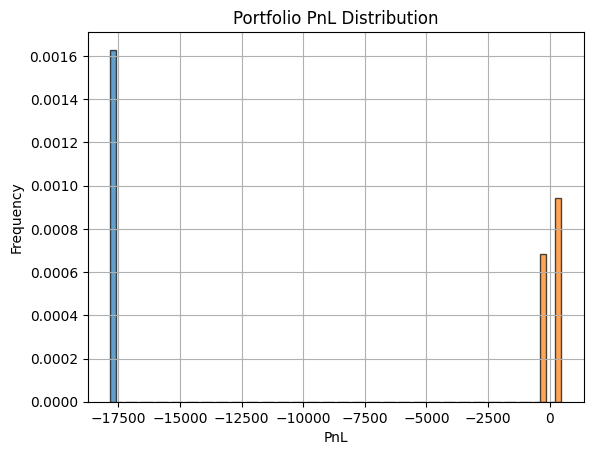

In [ ]:
# Run historical simulation
hist_sim = portfolio.HistoricalSimulation(
    historical_yield_curve=historical_df,
    interval=1,
    alpha=0.05
)

print("Historical Simulation VaR and ES:")
print(hist_sim)

# Plot the PnL distribution
plt.hist(hist_sim['pnl_distribution'], bins=30, edgecolor='k', density=True, alpha=0.7)
plt.title("Portfolio PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid()
plt.show()